In [1]:
import shutil
import os
from huggingface_hub import constants

# Get the cache directory
cache_dir = constants.HF_HUB_CACHE
print(f"Cache directory: {cache_dir}")

# Check size before deletion
print("Size before clearing:")
!du -sh {cache_dir}

# Clear the cache manually
if os.path.exists(cache_dir):
    for item in os.listdir(cache_dir):
        item_path = os.path.join(cache_dir, item)
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
            print(f"Removed {item_path}")
        except Exception as e:
            print(f"Error removing {item_path}: {e}")
    
    print("\nSize after clearing:")
    !du -sh {cache_dir}
else:
    print(f"Cache directory {cache_dir} does not exist")

Cache directory: /home/sz4972/.cache/huggingface/hub
Size before clearing:
29G	/home/sz4972/.cache/huggingface/hub
Removed /home/sz4972/.cache/huggingface/hub/models--openai--clip-vit-large-patch14-336
Removed /home/sz4972/.cache/huggingface/hub/.locks
Removed /home/sz4972/.cache/huggingface/hub/models--xtuner--llava-phi-3-mini-hf
Removed /home/sz4972/.cache/huggingface/hub/models--ICTNLP--llava-mini-llama-3.1-8b

Size after clearing:
512	/home/sz4972/.cache/huggingface/hub


In [2]:
# Clear pip cache
!pip cache purge

# Clear Jupyter cache
jupyter_cache = os.path.expanduser("~/.jupyter/cache")
if os.path.exists(jupyter_cache):
    shutil.rmtree(jupyter_cache)
    print(f"Cleared Jupyter cache: {jupyter_cache}")

# Clear Python cache files
!find ~ -name "__pycache__" -type d -exec rm -rf {} + 2>/dev/null || true
!find ~ -name "*.pyc" -delete

# Clear other common caches
for cache_dir in [
    "~/.cache/pip",
    "~/.cache/torch",
    "~/.cache/tensorflow",
    "~/.cache/models"
]:
    expanded_dir = os.path.expanduser(cache_dir)
    if os.path.exists(expanded_dir):
        try:
            shutil.rmtree(expanded_dir)
            print(f"Cleared {expanded_dir}")
        except Exception as e:
            print(f"Error clearing {expanded_dir}: {e}")

Files removed: 84
Cleared /home/sz4972/.cache/pip


In [3]:
!pip install torch numpy av transformers huggingface_hub tqdm pandas librosa nltk protobuf sentencepiece opencv-python
!pip install 'accelerate>=0.26.0'
!pip install pydub librosa soundfile pandas tqdm fastapi uvicorn decord seaborn xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


### 在运行此笔记本之前，请将变量 **VIDEO_FOLDER** 更改为您的视频文件夹名称，并将 **VIDEO_SHEET_CSV** 更改为您的 CSV 表，该表有每个视频 ID 到其对应的点赞数。

### Video Features

In [4]:
import os
import subprocess
import json
import pandas as pd
from tqdm import tqdm

# Define the paths to the video folder and CSV files
VIDEO_FOLDER = 'videos_new' #change name to your own video folder
OUTPUT_CSV = 'video_features_new.csv'
VIDEO_SHEET_CSV = 'video_sheet.csv'  #change name to your .csv sheet with video likes info

def get_ffprobe_metadata(video_path):
    """
    Extracts metadata from a video file using ffprobe.

    Args:
        video_path (str): Path to the video file.

    Returns:
        dict: A dictionary containing video metadata.
    """
    metadata = {}
    try:
        # Construct ffprobe command
        cmd = [
            'ffprobe',
            '-v', 'error',
            '-print_format', 'json',
            '-show_format',
            '-show_streams',
            video_path
        ]

        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # Parse the JSON output
        ffprobe_output = json.loads(result.stdout)

        # Extract general format info
        format_info = ffprobe_output.get('format', {})
        metadata['filename'] = os.path.basename(video_path)
        metadata['duration_seconds'] = float(format_info.get('duration', 0))
        metadata['file_size_MB'] = float(format_info.get('size', 0)) / (1024 * 1024)

        # Initialize fields
        metadata['fps'] = None
        metadata['width'] = None
        metadata['height'] = None
        metadata['codec'] = None
        metadata['has_audio'] = False
        metadata['audio_fps'] = None
        metadata['audio_channels'] = None
        metadata['num_frames'] = 0

        # Iterate over streams
        streams = ffprobe_output.get('streams', [])
        for stream in streams:
            if stream.get('codec_type') == 'video':
                metadata['codec'] = stream.get('codec_name', 'Unknown')
                metadata['width'] = stream.get('width', 0)
                metadata['height'] = stream.get('height', 0)
                # Calculate fps
                r_frame_rate = stream.get('r_frame_rate', '0/0')
                nums = r_frame_rate.split('/')
                if len(nums) == 2 and int(nums[1]) != 0:
                    metadata['fps'] = float(nums[0]) / float(nums[1])
                # Number of frames
                if 'nb_frames' in stream:
                    metadata['num_frames'] = int(stream['nb_frames'])
            elif stream.get('codec_type') == 'audio':
                metadata['has_audio'] = True
                metadata['audio_fps'] = float(stream.get('sample_rate', 0))
                metadata['audio_channels'] = int(stream.get('channels', 0))

    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        metadata = {
            'filename': os.path.basename(video_path),
            'duration_seconds': None,
            'fps': None,
            'width': None,
            'height': None,
            'num_frames': None,
            'file_size_MB': None,
            'codec': None,
            'has_audio': None,
            'audio_fps': None,
            'audio_channels': None
        }

    return metadata

def merge_video_metadata(df_metadata, info_csv):
    """
    Merges the extracted metadata with additional video information.

    Args:
        df_metadata (pd.DataFrame): DataFrame containing video metadata.
        info_csv (str): Path to 'video_info.csv'.

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    # Extract 'id' by removing the extension and converting to integer
    try:
        df_metadata['id'] = df_metadata['filename'].apply(lambda x: int(os.path.splitext(x)[0]))
    except ValueError as ve:
        print("Error extracting 'id' from filenames. Ensure all filenames before '.mp4' are integers.")
        print(ve)
        # Optionally, handle or remove problematic rows
        raise

    # Debugging: Print some IDs to verify
    print("Sample 'id' values:")
    print(df_metadata['id'].head())

    # Drop existing 'title', 'publish_time', 'likes' columns if present
    columns_to_drop = ['title', 'publish_time', 'likes']
    df_metadata = df_metadata.drop(columns=[col for col in columns_to_drop if col in df_metadata.columns])

    # Read the additional video info CSV
    try:
        df_info = pd.read_csv(info_csv)
    except FileNotFoundError:
        print(f"Error: The file '{info_csv}' does not exist.")
        return pd.DataFrame()  # Return empty DataFrame or handle as needed

    # Rename relevant columns for clarity and consistency
    df_info = df_info.rename(columns={
        '序号': 'id',
        '标题': 'title',
        '发布时间': 'publish_time',
        '点赞数': 'likes'
    })

    # Ensure 'id' in df_info is of integer type
    df_info['id'] = df_info['id'].astype(int)

    # Merge the DataFrames on 'id'
    merged_df = pd.merge(
        df_metadata,
        df_info[['id', 'title', 'publish_time', 'likes']],
        on='id',
        how='left'  # Use left join to retain all metadata entries
    )

    # Check for any missing merges
    missing_info = merged_df[merged_df['title'].isnull()]
    if not missing_info.empty:
        print("Warning: The following video IDs did not have matching entries in 'video_info.csv':")
        print(missing_info['id'].tolist())

    # Drop the temporary 'id' column as it's no longer needed
    merged_df = merged_df.drop(columns=['id'])

    return merged_df

def main():
    # Verify that ffprobe is accessible
    from shutil import which
    if which('ffprobe') is None:
        print("Error: ffprobe is not installed or not found in PATH.")
        print("Please install ffmpeg (which includes ffprobe) and ensure it's accessible from the command line.")
        print("Refer to the installation instructions provided earlier.")
        return
    else:
        print("ffprobe is found in PATH.")

    # Get list of video files
    try:
        video_files = [f for f in os.listdir(VIDEO_FOLDER) if f.lower().endswith('.mp4')]
    except FileNotFoundError:
        print(f"Error: The directory '{VIDEO_FOLDER}' does not exist.")
        return

    if not video_files:
        print(f"No '.mp4' files found in the directory '{VIDEO_FOLDER}'.")
        return

    video_paths = [os.path.join(VIDEO_FOLDER, f) for f in video_files]

    # Initialize a list to store metadata dictionaries
    metadata_list = []

    # Iterate over each video and extract metadata
    for video_path in tqdm(video_paths, desc="Extracting metadata with ffprobe"):
        metadata = get_ffprobe_metadata(video_path)
        metadata_list.append(metadata)

    # Convert the list of dictionaries to a pandas DataFrame
    df_metadata = pd.DataFrame(metadata_list)

    # Reorder columns for better readability
    columns_order = [
        'filename',
        'duration_seconds',
        'fps',
        'width',
        'height',
        'num_frames',
        'file_size_MB',
        'codec',
        'has_audio',
        'audio_fps',
        'audio_channels'
    ]

    # Ensure all columns are present before reordering
    df_metadata = df_metadata.reindex(columns=columns_order)

    # Check if the additional CSV file exists
    if not os.path.exists(VIDEO_SHEET_CSV):
        print(f"Error: The file '{VIDEO_SHEET_CSV}' does not exist.")
        print("Please ensure the additional CSV file is present in the working directory.")
        return

    # Perform the merge
    try:
        merged_df = merge_video_metadata(df_metadata, VIDEO_SHEET_CSV)
    except Exception as e:
        print(f"An error occurred during merging: {e}")
        return

    if merged_df.empty:
        print("Merged DataFrame is empty. Exiting.")
        return

    # Reorder columns to include the new fields
    final_columns_order = [
        'filename',
        'duration_seconds',
        'fps',
        'width',
        'height',
        'num_frames',
        'file_size_MB',
        'codec',
        'has_audio',
        'audio_fps',
        'audio_channels',
        'title',
        'publish_time',
        'likes'
    ]

    # Ensure all final columns are present
    missing_final_cols = [col for col in final_columns_order if col not in merged_df.columns]
    if missing_final_cols:
        print(f"Warning: The following expected columns are missing in the merged DataFrame: {missing_final_cols}")
        # Optionally, handle missing columns, e.g., fill with NaN
        for col in missing_final_cols:
            merged_df[col] = pd.NA

    merged_df = merged_df[final_columns_order]

    # Save the merged DataFrame to a CSV file
    merged_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8-sig')
    print(f"Metadata extraction and merging complete. Metadata saved to '{OUTPUT_CSV}'.")

if __name__ == "__main__":
    main()

ffprobe is found in PATH.


Extracting metadata with ffprobe: 100%|██████████| 13/13 [00:01<00:00,  9.98it/s]


Sample 'id' values:
0    269
1    288
2    276
3    283
4    268
Name: id, dtype: int64
Metadata extraction and merging complete. Metadata saved to 'video_features_new.csv'.


### Video Embeddings

In [5]:
import os
import torch
import numpy as np
import cv2
from transformers import LlavaForConditionalGeneration, AutoProcessor
from tqdm.notebook import tqdm
import pandas as pd
import gc  # For garbage collection
import logging

# Set up basic logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def extract_video_frames(video_path, max_frames=8, target_size=(224, 224)):
    """
    Extract frames from a video and resize them to a consistent size.
    
    Args:
        video_path (str): Path to the video file.
        max_frames (int): Maximum number of frames to extract.
        target_size (tuple): (width, height) to resize frames to.
        
    Returns:
        np.ndarray: Extracted frames of shape (num_frames, height, width, 3).
    """
    try:
        # Open the video file
        cap = cv2.VideoCapture(video_path)
        
        # Check if the video opened successfully
        if not cap.isOpened():
            logger.error(f"Could not open video: {video_path}")
            raise ValueError(f"Could not open video: {video_path}")
        
        # Get video properties
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Handle videos with unknown frame count
        if total_frames <= 0:
            # Count frames manually
            total_frames = 0
            while True:
                ret, _ = cap.read()
                if not ret:
                    break
                total_frames += 1
            # Reset video to beginning
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        
        # If still no frames, return a dummy frame
        if total_frames == 0:
            logger.warning(f"No frames found in {video_path}, returning dummy frame")
            height, width = target_size[1], target_size[0]
            dummy_frame = np.zeros((1, height, width, 3), dtype=np.uint8)
            cap.release()
            return dummy_frame
        
        # Calculate which frames to extract (uniform sampling)
        num_frames = min(max_frames, total_frames)
        
        if num_frames == 1:
            frame_indices = [0]
        else:
            frame_indices = [int(i * (total_frames - 1) / (num_frames - 1)) for i in range(num_frames)]
        
        # Extract the selected frames
        frames = []
        for idx in frame_indices:
            # Set position to the desired frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if ret:
                # Resize to target size for consistency
                frame_resized = cv2.resize(frame, target_size)
                # Convert BGR to RGB (OpenCV uses BGR, but most models expect RGB)
                frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)
            else:
                # If frame reading failed, add a blank frame
                frames.append(np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8))
        
        # Release the video capture object
        cap.release()
        
        # If no frames were successfully extracted, return a dummy frame
        if len(frames) == 0:
            logger.warning(f"No frames were successfully extracted from {video_path}")
            dummy_frame = np.zeros((1, target_size[1], target_size[0], 3), dtype=np.uint8)
            return dummy_frame
        
        # Make sure we have the requested number of frames
        while len(frames) < max_frames and len(frames) > 0:
            frames.append(frames[-1].copy())  # Duplicate the last frame
        
        # Stack frames into a single array
        frames_array = np.stack(frames)
        
        return frames_array
        
    except Exception as e:
        logger.error(f"Error reading frames from {video_path}: {str(e)}")
        # Return a dummy frame if extraction fails
        dummy_frame = np.zeros((1, target_size[1], target_size[0], 3), dtype=np.uint8)
        return dummy_frame

def manual_process_frames(processor, frames, text):
    """
    Manually process frames to work around the patch_size bug in the LLaVA processor.
    
    This function emulates what the processor does but ensures the patch_size is set correctly.
    """
    # First ensure processor.image_processor exists
    if not hasattr(processor, 'image_processor'):
        raise ValueError("Processor does not have an image_processor attribute")
    
    # Process the images with the image processor
    image_inputs = processor.image_processor(images=frames, return_tensors="pt")
    
    # Process the text with the tokenizer
    text_inputs = processor.tokenizer(
        text,
        return_tensors="pt",
        padding="longest",
        truncation=True
    )
    
    # Combine the outputs
    inputs = {
        "pixel_values": image_inputs.pixel_values,
        "input_ids": text_inputs.input_ids,
        "attention_mask": text_inputs.attention_mask
    }
    
    return inputs

def extract_video_embedding(model, processor, video_path, device):
    """
    Extract embedding for a single video with the patched processor.
    """
    try:
        # Extract frames using OpenCV (resized to standard size)
        target_size = (224, 224)  # Common image size for vision models
        video = extract_video_frames(video_path, max_frames=8, target_size=target_size)
        
        # Prepare prompt
        prompt = "USER: <image>\nDescribe this video. ASSISTANT:"
        
        # Use manual processing to avoid the patch_size bug
        inputs = manual_process_frames(processor, video, prompt)
        
        # Move inputs to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get embedding
        with torch.no_grad():
            # Access the vision_tower directly from the model
            # Different LLaVA models may have different attribute names
            if hasattr(model, 'vision_tower'):
                vision_tower = model.vision_tower
            elif hasattr(model, 'model') and hasattr(model.model, 'vision_tower'):
                vision_tower = model.model.vision_tower
            elif hasattr(model, 'vision_model'):
                vision_tower = model.vision_model
            else:
                # Print model attributes to help diagnose
                logger.info(f"Model attributes: {dir(model)}")
                raise AttributeError("Could not find vision tower in model")
            
            # Get outputs from vision tower
            outputs = vision_tower(inputs["pixel_values"])
            
            # Extract visual features
            if hasattr(outputs, "pooler_output"):
                embedding = outputs.pooler_output.cpu().numpy()
            elif hasattr(outputs, "last_hidden_state"):
                # Use the [CLS] token or average all tokens
                last_hidden_state = outputs.last_hidden_state
                embedding = last_hidden_state.mean(dim=1).cpu().numpy()
            else:
                # Handle case where outputs is the tensor directly
                if isinstance(outputs, torch.Tensor):
                    embedding = outputs.mean(dim=1).cpu().numpy()
                else:
                    logger.info(f"Output attributes: {dir(outputs)}")
                    raise ValueError("Could not extract embedding from vision tower outputs")
        
        # Clear CUDA cache to free memory
        if device.type == "cuda":
            torch.cuda.empty_cache()
            
        return embedding
    
    except Exception as e:
        logger.error(f"Error processing {video_path}: {str(e)}")
        # Return a zero vector of the expected dimension
        if hasattr(model.config, "hidden_size"):
            embedding_size = model.config.hidden_size
        else:
            embedding_size = 768  # Default fallback
        return np.zeros((1, embedding_size))

def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    # Initialize model and processor
    model_name = "xtuner/llava-phi-3-mini-hf"
    logger.info(f"Loading model: {model_name}")
    
    # Load model
    model = LlavaForConditionalGeneration.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if device.type == "cuda" else torch.float32,
        device_map="auto" if device.type == "cuda" else None,
        low_cpu_mem_usage=True
    )
    model.eval()
    
    # Print model structure to help debug
    logger.info(f"Model keys: {dir(model)}")
    if hasattr(model, 'config'):
        logger.info(f"Model config: {model.config}")

    # Load processor
    processor = AutoProcessor.from_pretrained(model_name)
    processor.tokenizer.padding_side = "left"
    
    # Patch the processor's image_processor to ensure it has a patch_size
    # LLaVA Phi uses 14x14 patch size typically
    if hasattr(processor, 'image_processor') and not hasattr(processor.image_processor, 'patch_size'):
        processor.image_processor.patch_size = 14
        logger.info("Patched processor.image_processor to add patch_size=14")
    
    # Directory containing videos
    videos_dir = "videos_new"
    if not os.path.isdir(videos_dir):
        raise ValueError(f"Directory '{videos_dir}' does not exist.")

    # Supported video extensions
    video_extensions = {".mp4", ".mov", ".avi", ".mkv"}

    # List all video files
    video_files = [
        f for f in os.listdir(videos_dir)
        if os.path.splitext(f)[1].lower() in video_extensions
    ]

    if not video_files:
        raise ValueError(f"No video files found in directory '{videos_dir}'.")

    # Prepare list to hold filename and embeddings
    data = []

    logger.info(f"Found {len(video_files)} video files to process")
    logger.info("Processing videos and extracting embeddings...")
    
    # Process a single video first to debug
    if video_files:
        test_video = video_files[0]
        test_path = os.path.join(videos_dir, test_video)
        logger.info(f"Testing with video: {test_path}")
        try:
            # Get frames
            frames = extract_video_frames(test_path)
            logger.info(f"Frames extracted: {frames.shape}")
            
            # Process manually
            prompt = "USER: <image>\nDescribe this video. ASSISTANT:"
            inputs = manual_process_frames(processor, frames, prompt)
            logger.info(f"Manual processing successful, keys: {inputs.keys()}")
            
            # Do a test run with vision tower access
            logger.info("Trying to access vision tower...")
            with torch.no_grad():
                if hasattr(model, 'vision_model'):
                    logger.info("Found vision_model")
                    vision_tower = model.vision_model
                elif hasattr(model, 'model') and hasattr(model.model, 'vision_tower'):
                    logger.info("Found model.model.vision_tower")
                    vision_tower = model.model.vision_tower
                elif hasattr(model, 'vision_tower'):
                    logger.info("Found vision_tower")
                    vision_tower = model.vision_tower
                else:
                    logger.info(f"Model dir: {dir(model)}")
                    if hasattr(model, 'model'):
                        logger.info(f"Model.model dir: {dir(model.model)}")
                    raise ValueError("Could not find vision tower")
                
                logger.info("Vision tower access successful")
        except Exception as e:
            logger.error(f"Test processing failed: {e}")
    
    # Process all videos
    for video_file in tqdm(video_files, desc="Embedding Videos"):
        video_path = os.path.join(videos_dir, video_file)
        filename, _ = os.path.splitext(video_file)
        try:
            # Process the video and get embedding
            embedding = extract_video_embedding(model, processor, video_path, device)
            
            # Flatten and convert embedding to list for CSV
            embedding_list = embedding.flatten().tolist()
            
            data.append({
                "filename": filename,
                "embedding": embedding_list
            })
            
            # Force garbage collection to free memory
            gc.collect()
            if device.type == "cuda":
                torch.cuda.empty_cache()
                
        except Exception as e:
            logger.error(f"Error processing {video_file}: {e}")
            # Add a placeholder with zeros to maintain the list of filenames
            if hasattr(model.config, "hidden_size"):
                embedding_size = model.config.hidden_size
            else:
                embedding_size = 768  # Default fallback size
                
            data.append({
                "filename": filename,
                "embedding": [0.0] * embedding_size
            })

    # Convert data to DataFrame
    df = pd.DataFrame(data)

    # Save to CSV
    output_csv = "video_embeddings_mini_llama.csv"
    # To store embeddings as strings, join the list elements
    df['embedding'] = df['embedding'].apply(lambda x: ",".join(map(str, x)))
    df.to_csv(output_csv, index=False)
    logger.info(f"Embeddings saved to {output_csv}")

if __name__ == "__main__":
    main()

2025-03-19 06:48:42,793 - INFO - Using device: cpu
2025-03-19 06:48:42,793 - INFO - Loading model: xtuner/llava-phi-3-mini-hf


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.31G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

2025-03-19 06:49:36,204 - INFO - Model keys: ['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_assisted_decoding', '_auto_class', '_autoset_attn_implementation', '_backward_compatibility_gradient_checkpointing', '_backward_hooks', '_backward_pre_hooks', '_beam_search', '_buffers', '_call_impl', '_check_and_enable_flash_attn_2', '_check_and_enable_flex_attn', '_check_and_enable_sdpa', '_compiled_call_impl', '_constrained_beam_search', '_contrastive_search', '_convert_head_mask_to_5d', '_copy_lm_head_original_to_resized', '_create_repo', '_dispatch_accelerate_model', '_dola_decoding', '_expand

preprocessor_config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/8.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/978 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

2025-03-19 06:49:37,302 - INFO - Patched processor.image_processor to add patch_size=14
2025-03-19 06:49:37,303 - INFO - Found 13 video files to process
2025-03-19 06:49:37,303 - INFO - Processing videos and extracting embeddings...
2025-03-19 06:49:37,303 - INFO - Testing with video: videos_new/269.mp4
2025-03-19 06:49:38,524 - INFO - Frames extracted: (8, 224, 224, 3)
2025-03-19 06:49:38,570 - INFO - Manual processing successful, keys: dict_keys(['pixel_values', 'input_ids', 'attention_mask'])
2025-03-19 06:49:38,570 - INFO - Trying to access vision tower...
2025-03-19 06:49:38,571 - INFO - Found vision_tower
2025-03-19 06:49:38,571 - INFO - Vision tower access successful


Embedding Videos:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-19 06:51:47,143 - INFO - Embeddings saved to video_embeddings_mini_llama.csv


### Video ASR

In [6]:
import os
import torch
import tempfile
from tqdm.notebook import tqdm
import pandas as pd
import logging
import subprocess
import gc

# Set up basic logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Whisper supported languages
WHISPER_LANGUAGES = {
    "en": "English",
    "zh": "Chinese",
    "de": "German",
    "es": "Spanish",
    "ru": "Russian",
    "ko": "Korean",
    "fr": "French",
    "ja": "Japanese",
    "pt": "Portuguese",
    "tr": "Turkish",
    "pl": "Polish",
    "ca": "Catalan",
    "nl": "Dutch",
    "ar": "Arabic",
    "sv": "Swedish",
    "it": "Italian",
    "id": "Indonesian",
    "hi": "Hindi",
    "fi": "Finnish",
    "vi": "Vietnamese",
    "he": "Hebrew",
    "uk": "Ukrainian",
    "el": "Greek",
    "ms": "Malay",
    "cs": "Czech",
    "ro": "Romanian",
    "da": "Danish",
    "hu": "Hungarian",
    "ta": "Tamil",
    "no": "Norwegian",
    "th": "Thai",
    "ur": "Urdu",
    "hr": "Croatian",
    "bg": "Bulgarian",
    "lt": "Lithuanian",
    "la": "Latin",
    "mi": "Maori",
    "ml": "Malayalam",
    "cy": "Welsh",
    "sk": "Slovak",
    "te": "Telugu",
    "fa": "Persian",
    "lv": "Latvian",
    "bn": "Bengali",
    "sr": "Serbian",
    "az": "Azerbaijani",
    "sl": "Slovenian",
    "kn": "Kannada",
    "et": "Estonian",
    "mk": "Macedonian",
    "br": "Breton",
    "eu": "Basque",
    "is": "Icelandic",
    "hy": "Armenian",
    "ne": "Nepali",
    "mn": "Mongolian",
    "bs": "Bosnian",
    "kk": "Kazakh",
    "sq": "Albanian",
    "sw": "Swahili",
    "gl": "Galician",
    "mr": "Marathi",
    "pa": "Punjabi",
    "si": "Sinhala",
    "km": "Khmer",
    "sn": "Shona",
    "yo": "Yoruba",
    "so": "Somali",
    "af": "Afrikaans",
    "oc": "Occitan",
    "ka": "Georgian",
    "be": "Belarusian",
    "tg": "Tajik",
    "sd": "Sindhi",
    "gu": "Gujarati",
    "am": "Amharic",
    "yi": "Yiddish",
    "lo": "Lao",
    "uz": "Uzbek",
    "fo": "Faroese",
    "ht": "Haitian Creole",
    "ps": "Pashto",
    "tk": "Turkmen",
    "nn": "Nynorsk",
    "mt": "Maltese",
    "sa": "Sanskrit",
    "lb": "Luxembourgish",
    "my": "Myanmar",
    "bo": "Tibetan",
    "tl": "Tagalog",
    "mg": "Malagasy",
    "as": "Assamese",
    "tt": "Tatar",
    "haw": "Hawaiian",
    "ln": "Lingala",
    "ha": "Hausa",
    "ba": "Bashkir",
    "jw": "Javanese",
    "su": "Sundanese",
}

def extract_audio_directly(video_path, output_dir=None):
    """
    Use direct FFmpeg command to extract audio without any processing.
    
    Args:
        video_path (str): Path to the video file.
        output_dir (str, optional): Directory to save the output. If None, uses temp dir.
        
    Returns:
        str: Path to the extracted audio file.
    """
    try:
        # Setup output path
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            video_name = os.path.splitext(os.path.basename(video_path))[0]
            output_path = os.path.join(output_dir, f"{video_name}.wav")
        else:
            temp_dir = tempfile.gettempdir()
            video_name = os.path.splitext(os.path.basename(video_path))[0]
            output_path = os.path.join(temp_dir, f"{video_name}.wav")
        
        logger.info(f"Extracting original audio directly from {video_path}")
        
        # Basic command to extract audio with minimal processing
        cmd = [
            'ffmpeg',
            '-i', video_path,  # Input file
            '-vn',             # No video
            '-acodec', 'pcm_s16le',  # PCM format (standard for WAV)
            '-ar', '16000',    # 16kHz (Whisper's expected sample rate)
            '-ac', '1',        # Mono
            '-y',              # Overwrite if exists
            output_path        # Output file
        ]
        
        # Run FFmpeg command
        subprocess.run(cmd, check=True, capture_output=True)
        
        if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
            logger.info(f"Audio extracted successfully to {output_path}")
            return output_path
        else:
            logger.error("Failed to create valid audio file")
            raise ValueError("Audio extraction produced empty file")
            
    except Exception as e:
        logger.error(f"Error extracting audio directly: {e}")
        raise

def transcribe_audio_in_chunks(transcribe_function, audio_path, max_retry=3):
    """
    Handle transcription by retrying or providing fallback values.
    
    Args:
        transcribe_function: Function to use for transcription
        audio_path: Path to the audio file
        max_retry: Maximum number of retry attempts
        
    Returns:
        dict: Transcription result or error message
    """
    for attempt in range(max_retry):
        try:
            logger.info(f"Transcription attempt {attempt+1}/{max_retry}")
            result = transcribe_function(audio_path)
            # If successful, return the result
            return result
        except Exception as e:
            logger.warning(f"Attempt {attempt+1} failed: {e}")
            # Force garbage collection
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # If all attempts failed, return error message
    return {"text": "Failed to transcribe after multiple attempts", "language": None}

def process_single_video(video_path, model_size="small", language=None, translate=False, 
                         output_dir=None, keep_audio=False):
    """
    Process a single video file to extract audio and transcribe it.
    
    Args:
        video_path (str): Path to the video file.
        model_size (str): Size of the Whisper model to use.
        language (str): Language code to force (e.g., "en", "fr"). If None, auto-detect.
        translate (bool): Whether to translate non-English speech to English.
        output_dir (str, optional): Directory to save the audio file.
        keep_audio (bool): Whether to keep the extracted audio file.
        
    Returns:
        dict: Contains transcription text and detected language.
    """
    try:
        # Extract audio
        audio_path = extract_audio_directly(video_path, output_dir if keep_audio else None)
        
        # Use a separate function to handle transcription to avoid kernel crashes 
        # if the import fails
        def setup_and_transcribe(audio_path):
            # Import whisper only when needed to avoid memory pressure
            try:
                import whisper
                
                # Load the model (specifying a smaller model to prevent crashes)
                logger.info(f"Loading whisper {model_size} model")
                model = whisper.load_model(model_size)
                
                # Set task based on whether translation is requested
                task = "translate" if translate else "transcribe"
                
                # Detect language if not specified
                if language is None:
                    logger.info("Detecting language...")
                    # Use a smaller portion of audio for language detection
                    audio = whisper.load_audio(audio_path)
                    audio = whisper.pad_or_trim(audio)
                    
                    # Get the log mel spectrogram
                    mel = whisper.log_mel_spectrogram(audio).to(model.device)
                    
                    # Detect the language
                    _, probs = model.detect_language(mel)
                    detected_lang = max(probs, key=probs.get)
                    
                    logger.info(f"Detected language: {detected_lang} ({WHISPER_LANGUAGES.get(detected_lang, 'Unknown')})")
                    detected_language = detected_lang
                else:
                    logger.info(f"Using specified language: {language}")
                    detected_language = language
                
                # Transcribe the audio
                logger.info(f"Transcribing {audio_path} in {detected_language} (task: {task})")
                result = model.transcribe(
                    audio_path, 
                    language=detected_language,
                    task=task,
                    fp16=False  # Disable fp16 for stability
                )
                
                # Free memory immediately after transcription
                del model
                gc.collect()
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                
                return {
                    "text": result["text"],
                    "language": detected_language
                }
            except ImportError:
                logger.error("Failed to import whisper. Make sure it's installed.")
                return {"text": "Error: Whisper not installed", "language": None}
        
        # Transcribe with retries
        result = transcribe_audio_in_chunks(setup_and_transcribe, audio_path)
        
        # Clean up if not keeping audio
        if not keep_audio and output_dir is None and os.path.exists(audio_path):
            os.remove(audio_path)
            logger.info(f"Deleted temporary audio file: {audio_path}")
        
        return result
    
    except Exception as e:
        logger.error(f"Error processing video {video_path}: {e}")
        return {"text": f"Error: {str(e)}", "language": None}

def transcribe_videos(videos_dir="videos_new", output_csv="video_transcriptions.csv", 
                      audio_dir=None, keep_audio=False, model_size="small",
                      language=None, translate=False):
    """
    Transcribe all videos in a directory.
    
    Args:
        videos_dir (str): Directory containing videos.
        output_csv (str): Output CSV file path.
        audio_dir (str, optional): Directory to save audio files.
        keep_audio (bool): Whether to keep the extracted audio files.
        model_size (str): Whisper model size ('tiny', 'base', 'small', 'medium').
        language (str, optional): Language code to force. If None, auto-detect.
        translate (bool): Whether to translate non-English speech to English.
        
    Returns:
        pd.DataFrame: DataFrame with transcriptions.
    """
    # List videos
    if not os.path.isdir(videos_dir):
        raise ValueError(f"Directory not found: {videos_dir}")
    
    video_extensions = {".mp4", ".mov", ".avi", ".mkv"}
    video_files = [
        f for f in os.listdir(videos_dir)
        if os.path.splitext(f)[1].lower() in video_extensions
    ]
    
    if not video_files:
        raise ValueError(f"No video files found in {videos_dir}")
    
    logger.info(f"Found {len(video_files)} videos in {videos_dir}")
    
    # Install whisper if needed
    try:
        logger.info("Checking if whisper is installed...")
        import whisper
        logger.info("Whisper is already installed")
    except ImportError:
        logger.info("Installing whisper...")
        import subprocess
        subprocess.check_call(["pip", "install", "openai-whisper"])
        logger.info("Whisper installed successfully")
    
    # Process each video
    results = []
    for video_file in tqdm(video_files, desc="Processing Videos"):
        video_path = os.path.join(videos_dir, video_file)
        filename, _ = os.path.splitext(video_file)
        
        try:
            # Process the video
            result = process_single_video(
                video_path=video_path,
                model_size=model_size,
                language=language,
                translate=translate,
                output_dir=audio_dir,
                keep_audio=keep_audio
            )
            
            # Add to results
            results.append({
                "filename": filename,
                "transcription": result["text"],
                "detected_language": result["language"],
                "language_name": WHISPER_LANGUAGES.get(result["language"], "Unknown")
            })
            
            logger.info(f"Processed {filename}: {result['text'][:50]}...")
            logger.info(f"Detected language: {result['language']} ({WHISPER_LANGUAGES.get(result['language'], 'Unknown')})")
            
            # Free memory
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
        except Exception as e:
            logger.error(f"Error processing {filename}: {e}")
            results.append({
                "filename": filename,
                "transcription": f"Error: {str(e)}",
                "detected_language": None,
                "language_name": "Unknown"
            })
            
        # Save results after each video to prevent losing progress
        pd.DataFrame(results).to_csv(output_csv, index=False)
        logger.info(f"Progress saved to {output_csv}")
    
    # Create final DataFrame
    df = pd.DataFrame(results)
    
    # Save to CSV (final save)
    df.to_csv(output_csv, index=False)
    logger.info(f"Saved transcriptions to {output_csv}")
    
    return df

In [7]:
df = transcribe_videos(
    videos_dir="videos_new",
    output_csv="transcriptions.csv",
    audio_dir="audio_files",
    keep_audio=True,
    model_size="small", # Options: tiny, base, small, medium, large
    language=None,  # Auto-detect language (you can set a language if all your videos are of one language)
    translate=False  # Set to True to translate non-English to English
)

2025-03-19 06:51:48,490 - INFO - Found 13 videos in videos_new
2025-03-19 06:51:48,490 - INFO - Checking if whisper is installed...
2025-03-19 06:51:49,540 - INFO - Whisper is already installed


Processing Videos:   0%|          | 0/13 [00:00<?, ?it/s]

2025-03-19 06:51:49,556 - INFO - Extracting original audio directly from videos_new/269.mp4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-03-19 06:51:49,861 - INFO - Audio extracted successfully to audio_files/269.wav
2025-03-19 06:51:49,861 - INFO - Transcription attempt 1/3
2025-03-19 06:51:49,862 - INFO - Loading whisper small model
2025-03-19 06:51:53,483 - INFO - Detecting language...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2025-03-19 06:55:03,065 - INFO - Processed 268:  Welcome to NYU Shanghai's cafeteria. This is wher...
2025-03-19 06:55:03,066 - INFO - Detected language: en (English)
2025-03-19 06:55:03,257 - INFO - Progress saved to transcriptions.csv
2025-03-19 06:55:03,259 - INFO - Extracting original audio directly from videos_new/280.mp4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-03-19 06:55:03,543 - INFO - Audio extracted successfully to audio_files/280.wav
2025-03-19 06:55:03,544 - INFO - Transcription attempt 1/3
2025-03-19 06:55:03,544 - INFO - Loading whisper small model
2025-03-19 06:55:06,781 - INFO - Detecting language...
huggingface/tokenizers: The current process just got forked, after parallelism has alre

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-03-19 06:56:48,182 - INFO - Processed 289:  Today's vlog is kind of special. Let's celebrate ...
2025-03-19 06:56:48,183 - INFO - Detected language: en (English)
2025-03-19 06:56:48,377 - INFO - Progress saved to transcriptions.csv
2025-03-19 06:56:48,379 - INFO - Extracting original audio directly from videos_new/282.mp4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-03-19 06:56:48,667

### Merge into one .csv file

In [13]:
import pandas as pd

# Read the CSV files
df_transcriptions = pd.read_csv("transcriptions.csv")
df_embeddings = pd.read_csv("video_embeddings_mini_llama.csv")
df_metadata = pd.read_csv("video_features_new.csv")

# Convert the 'filename' columns to string in all dataframes
df_transcriptions["filename"] = df_transcriptions["filename"].astype(str)
df_embeddings["filename"] = df_embeddings["filename"].astype(str)
df_metadata["filename"] = df_metadata["filename"].astype(str)

# Remove the '.mp4' extension from the metadata filenames for a proper join
df_metadata['filename'] = df_metadata['filename'].str.replace('.mp4', '', regex=False)

# Merge the dataframes on the "filename" column
df_merged = pd.merge(df_transcriptions, df_embeddings, on="filename", how="outer")
df_merged = pd.merge(df_merged, df_metadata, on="filename", how="outer")

# Write the merged DataFrame to a new CSV file
df_merged.to_csv("combined.csv", index=False)

### Predicting likes

Loading data...
Data loaded successfully with 13 rows and 18 columns

--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   filename           13 non-null     int64  
 1   transcription      13 non-null     object 
 2   detected_language  13 non-null     object 
 3   language_name      13 non-null     object 
 4   embedding          13 non-null     object 
 5   duration_seconds   13 non-null     float64
 6   fps                13 non-null     float64
 7   width              13 non-null     int64  
 8   height             13 non-null     int64  
 9   num_frames         13 non-null     int64  
 10  file_size_MB       13 non-null     float64
 11  codec              13 non-null     object 
 12  has_audio          13 non-null     bool   
 13  audio_fps          13 non-null     float64
 14  audio_channels     13 non-null  

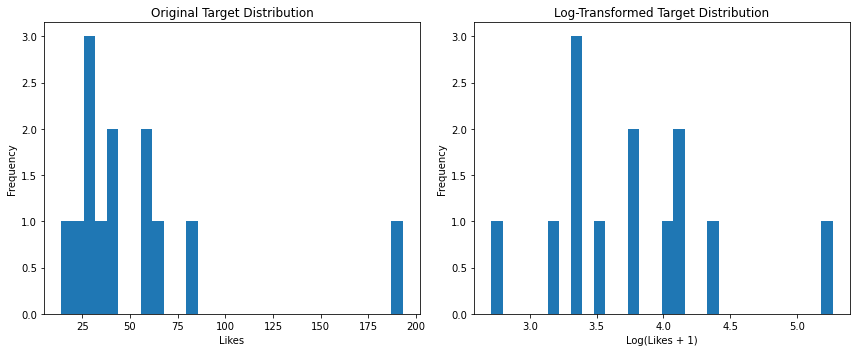

Using log-transformed target for modeling
Selected 8217 numeric features and 7 categorical features
Training set: 10 samples
Test set: 3 samples

--- Building prediction models ---

Training RandomForest...
RandomForest Results:
  R² Score: -0.0465
  RMSE (log scale): 0.3847
  MAE (log scale): 0.3384
  RMSE (original scale): 14.2713
  MAE (original scale): 13.1346

Training GradientBoosting...
GradientBoosting Results:
  R² Score: 0.4085
  RMSE (log scale): 0.2892
  MAE (log scale): 0.2283
  RMSE (original scale): 9.5197
  MAE (original scale): 8.2100

Training ElasticNet...
ElasticNet Results:
  R² Score: 0.1902
  RMSE (log scale): 0.3384
  MAE (log scale): 0.3088
  RMSE (original scale): 12.1593
  MAE (original scale): 11.7828

Training XGBoost...
XGBoost Results:
  R² Score: -0.3681
  RMSE (log scale): 0.4398
  MAE (log scale): 0.4207
  RMSE (original scale): 28.7797
  MAE (original scale): 23.9705

Best model: GradientBoosting with R² = 0.4085


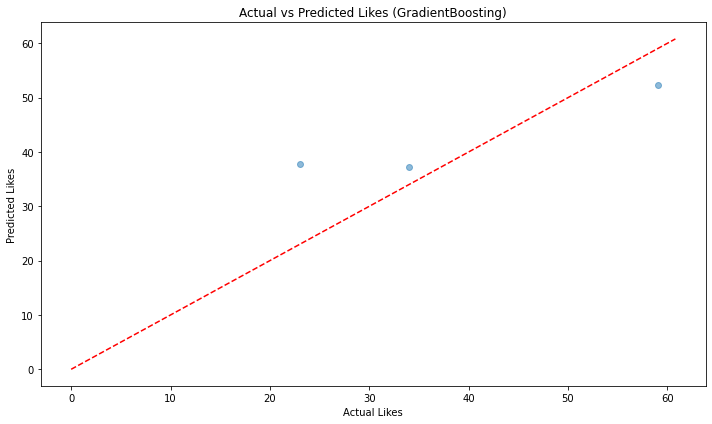

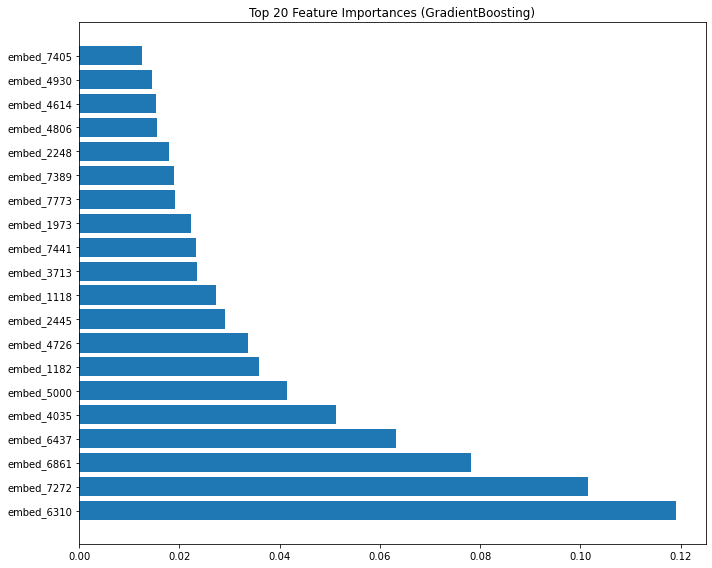


--- Tuning the best model ---
Tuning GradientBoosting with 3 parameters...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}

Tuned Model Results:
  R² Score: 0.4085
  RMSE (log scale): 0.2892
  MAE (log scale): 0.2283
  RMSE (original scale): 9.5194
  MAE (original scale): 8.2097


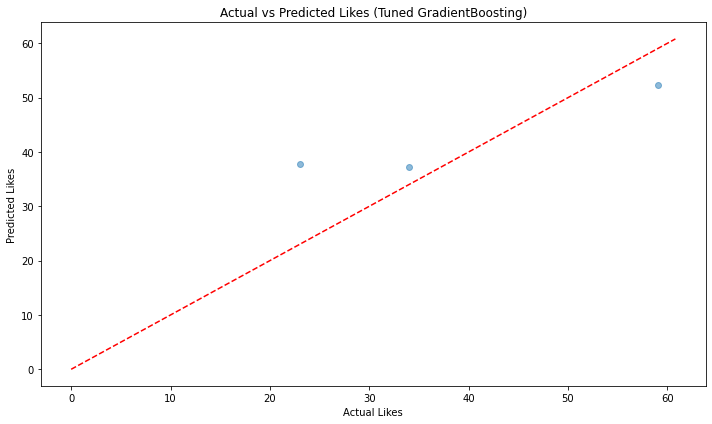


=== Model Training Complete ===

--- Predicting on new data ---

--- Processing video metadata ---
Successfully processed relative time from publish_time
Made predictions for 10 videos
Prediction statistics: min=27.00, max=193.00, mean=60.81

--- Example Predictions ---
Video: 283, Actual Likes: 27, Predicted Likes: 27.00
Video: 271, Actual Likes: 42, Predicted Likes: 42.00
Video: 276, Actual Likes: 193, Predicted Likes: 193.00
Video: 282, Actual Likes: 28, Predicted Likes: 28.00
Video: 269, Actual Likes: 59, Predicted Likes: 52.36
Video: 268, Actual Likes: 81, Predicted Likes: 81.00
Video: 288, Actual Likes: 28, Predicted Likes: 28.00
Video: 278, Actual Likes: 62, Predicted Likes: 62.00
Video: 274, Actual Likes: 57, Predicted Likes: 57.00
Video: 289, Actual Likes: 23, Predicted Likes: 37.74


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# 1. Load the data
print("Loading data...")
try:
    df = pd.read_csv("combined.csv")
    print(f"Data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
except Exception as e:
    print(f"Error loading data: {e}")
    
# 2. Explore the data
print("\n--- Data Overview ---")
print(df.info())

print("\n--- First few rows ---")
print(df.head())

print("\n--- Basic statistics ---")
print(df.describe())

print("\n--- Missing values ---")
print(df.isnull().sum())

# 3. Preprocessing

# 3.1 Extract numeric values from embedding column
def process_embeddings(df):
    """Process embeddings column from string to numeric features"""
    print("\n--- Processing embeddings ---")
    
    if 'embedding' not in df.columns:
        print("Warning: 'embedding' column not found in the dataset")
        return df
    
    # Check if embeddings are already in list form or need parsing from string
    if isinstance(df['embedding'].iloc[0], str):
        # Convert string of comma-separated values to numpy arrays
        print("Converting embeddings from string to numeric arrays...")
        try:
            # Remove any rows with NaN embeddings
            df = df.dropna(subset=['embedding'])
            
            # Parse the embeddings string to a list of floats
            embeddings_list = df['embedding'].apply(lambda x: np.array([float(val) for val in x.split(',')]))
            
            # Get the dimension of the embeddings
            embedding_dim = len(embeddings_list.iloc[0])
            print(f"Embedding dimension: {embedding_dim}")
            
            # Create new columns for each embedding dimension
            for i in range(embedding_dim):
                df[f'embed_{i}'] = embeddings_list.apply(lambda x: x[i] if i < len(x) else np.nan)
                
            # Drop the original embedding column
            df = df.drop('embedding', axis=1)
            print(f"Successfully created {embedding_dim} embedding feature columns")
            
        except Exception as e:
            print(f"Error processing embeddings: {e}")
            # If there's an error, drop the embedding column
            df = df.drop('embedding', axis=1)
    
    return df

# 3.2 Process text transcriptions
def process_transcriptions(df):
    """Process text transcriptions into features"""
    print("\n--- Processing transcriptions ---")
    
    if 'transcription' not in df.columns:
        print("Warning: 'transcription' column not found in the dataset")
        return df, None
    
    # Clean transcriptions
    df['clean_transcription'] = df['transcription'].fillna('').astype(str).apply(lambda x: x.lower())
    
    # Extract basic text features
    df['transcript_length'] = df['clean_transcription'].apply(len)
    df['word_count'] = df['clean_transcription'].apply(lambda x: len(x.split()))
    
    # Create TF-IDF features
    print("Generating TF-IDF features from transcriptions...")
    tfidf = TfidfVectorizer(
        max_features=100,  # Limit to top 100 features
        min_df=2,          # Ignore terms that appear in less than 2 documents
        stop_words='english'
    )
    
    # Fit TF-IDF on non-empty transcriptions
    non_empty_mask = df['clean_transcription'].str.strip() != ''
    if non_empty_mask.sum() > 0:
        tfidf_matrix = tfidf.fit_transform(df.loc[non_empty_mask, 'clean_transcription'])
        
        # Use SVD to reduce dimensionality of TF-IDF features
        svd = TruncatedSVD(n_components=min(10, tfidf_matrix.shape[0], tfidf_matrix.shape[1]))
        tfidf_svd = svd.fit_transform(tfidf_matrix)
        
        # Add SVD components as features
        tfidf_cols = [f'tfidf_svd_{i}' for i in range(tfidf_svd.shape[1])]
        tfidf_df = pd.DataFrame(tfidf_svd, index=df.loc[non_empty_mask].index, columns=tfidf_cols)
        
        # Join with original dataframe
        df = df.join(tfidf_df)
        print(f"Added {len(tfidf_cols)} TF-IDF SVD features")
        
        # Return the fitted TF-IDF vectorizer for later use
        return df, (tfidf, svd)
    else:
        print("No valid transcriptions found for TF-IDF processing")
        return df, None

# 3.3 Preprocess video metadata
def process_metadata(df):
    """Process video metadata features"""
    print("\n--- Processing video metadata ---")
    
    # Handle duration
    if 'duration_seconds' in df.columns:
        # Create duration bins for potential categorical features
        df['duration_bins'] = pd.cut(df['duration_seconds'], 
                                    bins=[0, 15, 30, 60, 120, float('inf')],
                                    labels=['0-15s', '15-30s', '30-60s', '1-2min', '2min+'])
    
    # Create aspect ratio feature
    if 'width' in df.columns and 'height' in df.columns:
        df['aspect_ratio'] = df['width'] / df['height']
    
    # Create resolution category
    if 'width' in df.columns and 'height' in df.columns:
        def get_resolution_category(row):
            if pd.isnull(row['width']) or pd.isnull(row['height']):
                return 'Unknown'
            pixels = row['width'] * row['height']
            if pixels >= 1920*1080:
                return 'FullHD+'
            elif pixels >= 1280*720:
                return 'HD'
            elif pixels >= 640*480:
                return 'SD'
            else:
                return 'Low'
        
        df['resolution_category'] = df.apply(get_resolution_category, axis=1)
    
    # Process title feature
    if 'title' in df.columns:
        df['title_length'] = df['title'].fillna('').astype(str).apply(len)
        df['title_word_count'] = df['title'].fillna('').astype(str).apply(lambda x: len(x.split()))
    
    # Instead of trying to parse datetime, use the numeric value directly
    if 'publish_time' in df.columns:
        try:
            # Convert to numeric if it's not already
            df['publish_numeric'] = pd.to_numeric(df['publish_time'], errors='coerce')
            
            # Calculate relative time (larger values = newer)
            if not df['publish_numeric'].isnull().all():
                # Calculate days since oldest publication
                min_value = df['publish_numeric'].min()
                df['days_since_oldest'] = df['publish_numeric'] - min_value
                print(f"Successfully processed relative time from publish_time")
        except Exception as e:
            print(f"Note: Could not process publish_time as numeric: {e}")
    
    return df

# 3.4 Prepare final dataset for modeling
def prepare_modeling_data(df, target_col='likes'):
    """Prepare final dataset for modeling"""
    print("\n--- Preparing data for modeling ---")
    
    # Check if target column exists
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in dataset")
        return None, None, None
    
    # Drop rows with missing target values
    df_model = df.dropna(subset=[target_col])
    print(f"Rows after dropping missing target values: {df_model.shape[0]}")
    
    # Get the target variable
    y = df_model[target_col].copy()
    print(f"Target variable statistics: min={y.min()}, max={y.max()}, mean={y.mean():.2f}")
    
    # Log transform the target if it's skewed (common for 'likes' counts)
    y_log = np.log1p(y)  # log(1+x) to handle zeros
    
    # Plot target distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(y, bins=30)
    plt.title('Original Target Distribution')
    plt.xlabel('Likes')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(y_log, bins=30)
    plt.title('Log-Transformed Target Distribution')
    plt.xlabel('Log(Likes + 1)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # Select whether to use original or log-transformed target
    # Typically log-transform works better for skewed count data
    use_log = True
    if use_log:
        y_final = y_log
        print("Using log-transformed target for modeling")
    else:
        y_final = y
        print("Using original target for modeling")
    
    # Identify numeric and categorical columns
    # Exclude the target, ID columns, and any other non-feature columns
    exclude_cols = [target_col, 'filename', 'transcription', 'clean_transcription', 
                    'publish_time', 'embedding']
    
    # Extract column names by type
    numeric_cols = [col for col in df_model.select_dtypes(include=['int64', 'float64']).columns 
                   if col not in exclude_cols]
    
    categorical_cols = [col for col in df_model.select_dtypes(include=['object', 'category']).columns 
                       if col not in exclude_cols]
    
    # Add any boolean columns to categorical
    bool_cols = [col for col in df_model.select_dtypes(include=['bool']).columns 
                if col not in exclude_cols]
    categorical_cols.extend(bool_cols)
    
    print(f"Selected {len(numeric_cols)} numeric features and {len(categorical_cols)} categorical features")
    
    # Create feature matrix
    X = df_model[numeric_cols + categorical_cols].copy()
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_final, test_size=0.2, random_state=42
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Create feature list dictionaries
    features = {
        'numeric': numeric_cols,
        'categorical': categorical_cols
    }
    
    return (X_train, X_test, y_train, y_test), features, use_log

# 4. Modeling
def build_model(X_train, X_test, y_train, y_test, features, use_log=True):
    """Build and evaluate prediction models"""
    print("\n--- Building prediction models ---")
    
    # Create preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, features['numeric']),
            ('cat', categorical_transformer, features['categorical'])
        ]
    )
    
    # Define models to try
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'ElasticNet': ElasticNet(random_state=42),
    }
    
    try:
        # Add XGBoost if available
        models['XGBoost'] = XGBRegressor.XGBRegressor(random_state=42)
    except:
        print("XGBoost not available, skipping")
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # If we used log transform, convert predictions back to original scale
        if use_log:
            y_pred_original = np.expm1(y_pred)
            y_test_original = np.expm1(y_test)
        else:
            y_pred_original = y_pred
            y_test_original = y_test
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        # Calculate metrics on original scale
        rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        mae_original = mean_absolute_error(y_test_original, y_pred_original)
        
        # Store results
        results[name] = {
            'model': pipeline,
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'rmse_original': rmse_original,
            'mae_original': mae_original
        }
        
        print(f"{name} Results:")
        print(f"  R² Score: {r2:.4f}")
        print(f"  RMSE (log scale): {rmse:.4f}")
        print(f"  MAE (log scale): {mae:.4f}")
        print(f"  RMSE (original scale): {rmse_original:.4f}")
        print(f"  MAE (original scale): {mae_original:.4f}")
    
    # Find the best model based on R²
    best_model_name = max(results, key=lambda x: results[x]['r2'])
    print(f"\nBest model: {best_model_name} with R² = {results[best_model_name]['r2']:.4f}")
    
    # Plot actual vs predicted values for the best model
    plt.figure(figsize=(10, 6))
    best_model = results[best_model_name]['model']
    y_pred = best_model.predict(X_test)
    
    if use_log:
        plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
        plt.title(f'Actual vs Predicted Likes ({best_model_name})')
        plt.xlabel('Actual Likes')
        plt.ylabel('Predicted Likes')
    else:
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.title(f'Actual vs Predicted Likes ({best_model_name})')
        plt.xlabel('Actual Likes')
        plt.ylabel('Predicted Likes')
    
    # Add a perfect prediction line
    max_val = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.tight_layout()
    plt.show()
    
    # If the best model is RandomForest or GradientBoosting, show feature importance
    if best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
        feature_names = get_feature_names(best_model.named_steps['preprocessor'])
        
        if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
            importances = best_model.named_steps['regressor'].feature_importances_
            indices = np.argsort(importances)[-20:]  # Top 20 features
            
            plt.figure(figsize=(10, 8))
            plt.title(f'Top 20 Feature Importances ({best_model_name})')
            plt.barh(range(len(indices)), importances[indices], align='center')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
    
    return results

def get_feature_names(column_transformer):
    """Get feature names from column transformer"""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name == 'drop' or pipe == 'drop':
            continue
            
        if hasattr(pipe, 'get_feature_names_out'):
            if isinstance(features, slice):
                output_features.extend(pipe.get_feature_names_out())
            else:
                output_features.extend(pipe.get_feature_names_out(input_features=features))
        else:
            # For transformers without get_feature_names_out, try to reconstruct names
            for f in features:
                output_features.append(f"{name}__{f}")
    
    return output_features

# 5. Model tuning
def tune_best_model(X_train, X_test, y_train, y_test, features, best_model_name, use_log=True):
    """Tune the best model with hyperparameter optimization"""
    print("\n--- Tuning the best model ---")
    
    # Create preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, features['numeric']),
            ('cat', categorical_transformer, features['categorical'])
        ]
    )
    
    # Define parameter grids for different models
    param_grids = {
        'RandomForest': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__max_depth': [None, 10, 20],
            'regressor__min_samples_split': [2, 5, 10]
        },
        'GradientBoosting': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__learning_rate': [0.01, 0.1, 0.2],
            'regressor__max_depth': [3, 5, 7]
        },
        'ElasticNet': {
            'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],
            'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9]
        },
        'XGBoost': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__learning_rate': [0.01, 0.1, 0.2],
            'regressor__max_depth': [3, 5, 7]
        }
    }
    
    # Select model class based on name
    if best_model_name == 'RandomForest':
        model = RandomForestRegressor(random_state=42)
    elif best_model_name == 'GradientBoosting':
        model = GradientBoostingRegressor(random_state=42)
    elif best_model_name == 'ElasticNet':
        model = ElasticNet(random_state=42)
    elif best_model_name == 'XGBoost':
        model = XGBRegressor.XGBRegressor(random_state=42)
    else:
        print(f"Unknown model: {best_model_name}")
        return None
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Create grid search
    param_grid = param_grids[best_model_name]
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    print(f"Tuning {best_model_name} with {len(param_grid)} parameters...")
    grid_search.fit(X_train, y_train)
    
    # Print best parameters
    print(f"Best parameters: {grid_search.best_params_}")
    
    # Evaluate best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # If we used log transform, convert predictions back to original scale
    if use_log:
        y_pred_original = np.expm1(y_pred)
        y_test_original = np.expm1(y_test)
    else:
        y_pred_original = y_pred
        y_test_original = y_test
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate metrics on original scale
    rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae_original = mean_absolute_error(y_test_original, y_pred_original)
    
    print("\nTuned Model Results:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE (log scale): {rmse:.4f}")
    print(f"  MAE (log scale): {mae:.4f}")
    print(f"  RMSE (original scale): {rmse_original:.4f}")
    print(f"  MAE (original scale): {mae_original:.4f}")
    
    # Plot actual vs predicted values for the tuned model
    plt.figure(figsize=(10, 6))
    
    if use_log:
        plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
        plt.title(f'Actual vs Predicted Likes (Tuned {best_model_name})')
        plt.xlabel('Actual Likes')
        plt.ylabel('Predicted Likes')
    else:
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.title(f'Actual vs Predicted Likes (Tuned {best_model_name})')
        plt.xlabel('Actual Likes')
        plt.ylabel('Predicted Likes')
    
    # Add a perfect prediction line
    max_val = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.tight_layout()
    plt.show()
    
    return best_model

# 6. Make predictions on new data
def predict_on_new_data(model, new_data, features, tfidf_pipeline=None, use_log=True):
    """Make predictions on new data"""
    print("\n--- Predicting on new data ---")
    
    # Process the new data the same way as training data
    new_data_processed = new_data.copy()
    
    # Process embeddings if present
    if 'embedding' in new_data.columns:
        new_data_processed = process_embeddings(new_data_processed)
    
    # Process transcriptions if present and TF-IDF pipeline is provided
    if 'transcription' in new_data.columns and tfidf_pipeline is not None:
        tfidf, svd = tfidf_pipeline
        
        # Clean transcriptions
        new_data_processed['clean_transcription'] = new_data_processed['transcription'].fillna('').astype(str).apply(lambda x: x.lower())
        
        # Extract basic text features
        new_data_processed['transcript_length'] = new_data_processed['clean_transcription'].apply(len)
        new_data_processed['word_count'] = new_data_processed['clean_transcription'].apply(lambda x: len(x.split()))
        
        # Transform with pre-fitted TF-IDF and SVD
        non_empty_mask = new_data_processed['clean_transcription'].str.strip() != ''
        if non_empty_mask.sum() > 0:
            tfidf_matrix = tfidf.transform(new_data_processed.loc[non_empty_mask, 'clean_transcription'])
            tfidf_svd = svd.transform(tfidf_matrix)
            
            # Add SVD components as features
            tfidf_cols = [f'tfidf_svd_{i}' for i in range(tfidf_svd.shape[1])]
            
            # Check if columns already exist, and handle by removing them first
            existing_tfidf_cols = [col for col in tfidf_cols if col in new_data_processed.columns]
            if existing_tfidf_cols:
                new_data_processed = new_data_processed.drop(columns=existing_tfidf_cols)
            
            # Create DataFrame with TF-IDF features
            tfidf_df = pd.DataFrame(tfidf_svd, index=new_data_processed.loc[non_empty_mask].index, columns=tfidf_cols)
            
            # Use pandas concat instead of join to avoid column name conflicts
            new_data_processed = pd.concat([new_data_processed, tfidf_df], axis=1)
    
    # Process metadata
    new_data_processed = process_metadata(new_data_processed)
    
    # Select only features that were used in training
    # Ensure all required features exist in the data
    missing_features = [col for col in features['numeric'] + features['categorical'] if col not in new_data_processed.columns]
    if missing_features:
        print(f"Warning: Missing features in prediction data: {missing_features}")
        # Add missing features with NaN values
        for col in missing_features:
            new_data_processed[col] = np.nan
    
    X_new = new_data_processed[features['numeric'] + features['categorical']].copy()
    
    # Make predictions
    try:
        y_pred = model.predict(X_new)
        
        # If we used log transform, convert predictions back to original scale
        if use_log:
            y_pred_original = np.expm1(y_pred)
        else:
            y_pred_original = y_pred
        
        # Add predictions to the original data
        new_data['predicted_likes'] = y_pred_original
        
        print(f"Made predictions for {len(new_data)} videos")
        print(f"Prediction statistics: min={new_data['predicted_likes'].min():.2f}, max={new_data['predicted_likes'].max():.2f}, mean={new_data['predicted_likes'].mean():.2f}")
        
        return new_data
        
    except Exception as e:
        print(f"Error making predictions: {e}")
        return None
    
# 7. Main execution
def main():
    """Main execution function"""
    print("=== Video Likes Prediction Model ===")
    
    # Load data
    df = pd.read_csv("combined.csv")
    
    # Process data
    df = process_embeddings(df)
    df, tfidf_pipeline = process_transcriptions(df)
    df = process_metadata(df)
    
    # Prepare for modeling
    (X_train, X_test, y_train, y_test), features, use_log = prepare_modeling_data(df)
    
    # Build models
    results = build_model(X_train, X_test, y_train, y_test, features, use_log)
    
    # Find the best model
    best_model_name = max(results, key=lambda x: results[x]['r2'])
    
    # Tune the best model
    tuned_model = tune_best_model(X_train, X_test, y_train, y_test, features, best_model_name, use_log)
    
    # Save the tuned model (for demonstration)
    # We'd use joblib.dump(tuned_model, 'video_likes_model.joblib') in a real scenario
    
    print("\n=== Model Training Complete ===")
    
    # Example: Predict on new data (here we're using our test set as an example)
    # In a real scenario, you would load new data for prediction
    new_data_example = df.sample(min(10, len(df)))
    predictions = predict_on_new_data(tuned_model, new_data_example, features, tfidf_pipeline, use_log)
    
    if predictions is not None:
        print("\n--- Example Predictions ---")
        for _, row in predictions.iterrows():
            if 'likes' in row:
                print(f"Video: {row['filename']}, Actual Likes: {row['likes']}, Predicted Likes: {row['predicted_likes']:.2f}")
            else:
                print(f"Video: {row['filename']}, Predicted Likes: {row['predicted_likes']:.2f}")

# Run the main function
if __name__ == "__main__":
    main()